In [62]:
import pandas as pd
import json
from ast import literal_eval
import numpy as np
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt
import community as community_louvain
from itertools import combinations
import re
from nltk import word_tokenize
import seaborn as sns
import pickle
from copy import deepcopy
import requests
from bs4 import BeautifulSoup
import plotly.express as px
import os
import txt
import warnings
warnings.filterwarnings("ignore")

#define illustration colors
colors = ('#55a868', '#dd8552', '#8172b3', '#4c72b0' , '#c44e52', '#da8bc3', '#ccb974', '#64b5cd')

Notice that network visualisations are png images loaded in `markdown`. To see them, you must clone the entire git repository. 

# Motivation 

For the network science part of the assignment, we have chosen to create a social network of the game of thrones characters. This can be done in multiple ways e.g. by considering family ties or using information from the books (A song of ice and fire).  We, however, have chosen to subtract the information necessary to create a social network by accessing text data from [gameofthrones.fandom](https://gameofthrones.fandom.com). The fandom page comprises information of the characters, houses, episode etc. Regarding the later, the website has one page for each episode which consists of summaries of the episode of question. All summaries are partitioned into geographical location that is, for each episode page there is a short section with a summary for each geographical location where the act of that season takes place: 

**Episode name**
* Geographical location 1
* Geographical location 2
* ...


Since we are interested in creating a social network that holds information of connections between characters in _Game of Thrones_ not _A song of ice and fire_, we have chosen to create a social network based on the summaries of each episode. The general thought is that if two characters are mentioned in same summary they are placed in the same geographical location in an episode. In Game of Thrones the known worlds consist of the three continents Essos, Westeros and Sothoryos as well as a range of smaller ice lands. Most of the series takes place at Whesteros where the seven kingdoms as well as "the wall" and "beyond the wall" are located. Essos plays a large role as well as it is home to the 9 free cities and the Dothraki tribes. 

Most characters have a strong connection to a house of Westeros or a tribe/location in Essos. Change of loyalty happens and the main characters travels often, however no one travels fast and change of loyalty often means change of geographical locations. Thus, we find that it is interesting to build a social network of based on the geographical location of the characters.

The data used for the network science part of the assignment is accessed with webscrabing using beautiful soup. After webscrabing, data is stored in a pandas dataframe with the structure shown beneath:


In [63]:
df = pd.DataFrame(columns = ["season", "episode", "geo", "text"])
df

,season,episode,geo,text


Notice that _geo_ refers to the geographical location and that _text_ contains a document comprising the summary of the geographical location in the episode.

The goal for the network science park of the assignment is to visualise connections among the characters with graphs. Since most characters intersect at some point, we found it relevant to create separate graphs for each season. Thus, for each season we build an unweighted and a weighted graph. The weighted graph will have both node and link weights. Two characters are said to be connected if they are in the same geographical location in the same episode. Node size of the network is defined as number of times a character is mentioned and edge weight is defined as number of documents that two characters coappears in.

Moreover, to analyse how well the geographical locations defines the connections among characters we will look at communities of the network. The communities and the modularity of the partition together with prior knowledge of Game of Thrones will be used to analyse how well the graph, and thereby the data, describes the connections among characters.  


## Webscrabe/data functions 

Following methods are designed to get the relevant data: 
* `GetUrls`
* `SeasonList`
* `GetDocuments`
* `GetSectionName`
* `GetText`

Further describtions and use of the methods can be found beneath the webscrabe/data functions under **Get data**

In [64]:
def GetUrls(url):
    """
    Access relevant urls
    """

    req = requests.get(url)
    soup = BeautifulSoup(req.text, "html.parser")
    
    AllLinks = []
    for link in soup.find_all('a'):
        AllLinks.append(link.get('href'))
    
    idx = AllLinks.index('/wiki/Season_8')
    
    AllLinks = AllLinks[idx:idx+26]
    
    indices = [AllLinks.index("/wiki/Season_" +str(i)) for i in [8, 7, 6]]
    
    SeaLen = [indices[i+1]-indices[i]-1 for i in range(2)] + [len(AllLinks)-indices[2]-1]
    Seasons = SeaLen[0]*['Season_8'] + SeaLen[1]*['Season_7'] + SeaLen[2]*['Season_6']

    j = 0
    for i in indices: 
        del(AllLinks[i-j])
        j+=1

    return AllLinks, Seasons

def SeasonList(paths, season):
    
    return season*len(paths)
    

# Define end paths of troublesome urls

s1 = ['/wiki/Winter_Is_Coming', '/wiki/The_Kingsroad', '/wiki/Lord_Snow', 
      '/wiki/Cripples,_Bastards,_and_Broken_Things','/wiki/The_Wolf_and_the_Lion', '/wiki/A_Golden_Crown',
      '/wiki/You_Win_or_You_Die', '/wiki/The_Pointy_End', '/wiki/Baelor',  '/wiki/Fire_and_Blood']


s2 = ['/wiki/What_Is_Dead_May_Never_Die', '/wiki/The_Night_Lands', '/wiki/The_North_Remembers', 
     '/wiki/A_Man_Without_Honor', '/wiki/The_Old_Gods_and_the_New', '/wiki/The_Ghost_of_Harrenhal',
      '/wiki/Garden_of_Bones_(episode)', '/wiki/Valar_Morghulis', '/wiki/Blackwater', '/wiki/The_Prince_of_Winterfell']

s3 = ['/wiki/Valar_Dohaeris', '/wiki/Dark_Wings,_Dark_Words', '/wiki/Walk_of_Punishment_(episode)', 
     '/wiki/And_Now_His_Watch_Is_Ended','/wiki/Kissed_by_Fire', '/wiki/The_Climb', 
      '/wiki/The_Bear_and_the_Maiden_Fair_(episode)',
     '/wiki/Second_Sons_(episode)', '/wiki/The_Rains_of_Castamere_(episode)', '/wiki/Mhysa']

s4 = ['/wiki/Oathkeeper_(episode)', '/wiki/Breaker_of_Chains', '/wiki/The_Lion_and_the_Rose',
      '/wiki/Two_Swords', '/wiki/Mockingbird','/wiki/The_Laws_of_Gods_and_Men','/wiki/First_of_His_Name',
     '/wiki/The_Children','/wiki/The_Watchers_on_the_Wall','/wiki/The_Mountain_and_the_Viper']

s5 = ['/wiki/Sons_of_the_Harpy_(episode)', '/wiki/High_Sparrow_(episode)',
      '/wiki/The_House_of_Black_and_White', '/wiki/The_Wars_To_Come', 
     '/wiki/Mother%27s_Mercy', '/wiki/The_Dance_of_Dragons','/wiki/Hardhome_(episode)', 
      '/wiki/The_Gift', '/wiki/Unbowed,_Unbent,_Unbroken', '/wiki/Kill_the_Boy']



In [65]:
def GetDocuments(root, endpath):
    
    """
    Webscrabe and create soup and documents
    
    """
    url = root + endpath
    res = requests.get(url)
    html_page = res.content
    soup = BeautifulSoup(html_page, 'html.parser')
    text = soup.find_all(text=True)

    output = ''
    blacklist = [
        '[document]',
        'noscript',
        'header',
        'html',
        'meta',
        'head', 
        'input',
        'script',
        # there may be more elements you don't want, such as "style", etc.
    ]

    for t in text:
        if t.parent.name not in blacklist:
            output += '{} '.format(t)
            
    return soup, text, output

In [66]:
def GetSectionName(soup):
    """
    Find all captions
    
    """

    AllH = soup.find_all(['h2', 'h3'])
    for header in AllH:
        if header.span is not None: 
            header.span.unwrap()

    AllHeaders = [header.text for header in AllH]
    if 'Summary' in AllHeaders:
        Pre = AllHeaders.index('Summary')
    elif 'Synopsis' in AllHeaders: 
        Pre = AllHeaders.index('Synopsis')
    else: 
        print("something went wrong")
        return 
        
    Post = AllHeaders.index('Appearances')

    HeadlineName = AllHeaders[Pre+1:Post]
    return HeadlineName

In [67]:
def GetText(HeadlineNames):
    
    """
    Clean documents to retrieve relevant text
    
    """
    HeadlineNames += ['Appearances']

    # Unwrap text
    Texts = soup.find_all(['p','h2', 'h3'])
    for section in Texts: 
        if section is not None:
            if section.a is not None: 
                section.a.unwrap()
            elif section.span is not None: 
                section.span.unwrap()

    #S tore text in list
    Texts = [t.text for t in Texts]

    # Find section indices in Texts
    CaptionIndices = []
    for caption in HeadlineNames:         
        CaptionIndices.append(Texts.index(caption))

    # Store texts according to section
    SectionText = []
    for i in range(len(CaptionIndices)-1):
        SectionText.append(Texts[CaptionIndices[i]+1:CaptionIndices[i+1]])


    return SectionText




# Get data
The dataframe with the columns shown ealier is created by following procedure:  
1.  Access url for episodes of season 6, 7 and 8 with `GetUrls` and add the manually retrieved urls
For each episode: 
1. Webscrabe data with `GetDocuments` which find documents by searching for all text of a _soup_.
2. Find geographical location by searching for captions in documents with `GetSectionName`
3. Find summary of each geographical location in given episode by searching for text after captions with `GetText`

Data is stored in `GOT.csv`

In [ ]:
'''
#Initialise dataframe
df = pd.DataFrame(columns = ["season", "episode", "geo", "text"])

# Get all urls
url = "https://gameofthrones.fandom.com/wiki/"
EndAllUrls, Seasons = GetUrls(url)

#Add season 1 through 5
EndAllUrls = s1 +s2 + s3 + s4 + s5 + EndAllUrls 
s = []
for i,j in enumerate([s1, s2, s3, s4, s5]):
    s += SeasonList(j,['season' + str(i+1)])
Seasons = s + Seasons


root = 'https://gameofthrones.fandom.com'

AllCaptions = []
AllTexts = []
AllSeasons = []
AllEpisodes = []
for endpath, season in zip(EndAllUrls, Seasons):
    
    # Webscrabe
    #print(endpath)
    soup, text, output = GetDocuments(root, endpath)

    # Get section names
    Captions = GetSectionName(soup)

    # Get texts
    SectionText = GetText(Captions)
    
    AllCaptions = AllCaptions + Captions[:-1]
    AllTexts = AllTexts + SectionText
    AllSeasons = AllSeasons + [season] * len(Captions[:-1])
    
    AllEpisodes = AllEpisodes + [endpath[6:]]*len(Captions[:-1])
    
    
# Store in dataframe
df['episode'] = AllEpisodes
df['text'] = AllTexts
df['season'] = AllSeasons
df['geo'] = AllCaptions

# save to csv
df.to_csv('GOT.csv')
'''

# Basic stats:  Let's understand the data set 

## Cleaning and preprossesing 

To conduct the analysis, one needs a list  of characternames. A dictionary with characternames are stored in `charaters.json` which was found at the git repository `game-of-thrones` belonging to `jeffreylancaste`. However. not all names where nessesary thus a list of names where deleted. Names deleted can be found in the method  `CharacterNames`. Furthermore, `CharacterNames` add a few names we found where missing. The list of names will be referedto as `CN`.

`GetSeasonData` is used to substract data belonging to one season from the `GOT` dataframe.

To clean and preprocees data in `GOT` dataframe the methods `CleanData` and `GetFullyConnectedSubgraps` are utilised. 

`CleanData` performs following on the document of each row, i.e each geographical location summary, of the dataframe: 
* Remove newline
* Remove signs and 's to  make it possible to find names that are in genitiv or stands beside a sign. 
* Does NOT turn into uppercase into lowercase to avoid that names as e.g.  "Will" isto many times as. 

`GetFullyConnectedSubgraps` substracts connections from the `GOT` dataframe and add them to the dictionary called `Connections` as follows: 

* For each row in `GOT`, searh for each name in `CN` in the document from the _text_ column.
* If a name is present it is added to `Connections`. 
* Most characters are searched for by the use of their first name. However, some  characters have identical first names or go by e.g.  _Archmaester + *Name*_.  Thus some character are searched for by the use of their second name or the full name. Characters searched for by their full and second name respectivly can be found in `nh` and `n1`respectively. Both lists are defined in `GetFullyConnectedSubgraphs`.



In [69]:
def CharacterNames(path):
    """
    Function for characternames loading
    input: path to json
    returns: list of character names 
    """
    
    CN = []
    with open(path) as json_file:
        data = json.load(json_file)
        for p in data['characters']:
            CN.append(p['characterName'])

    removes = []
    for name in CN: 
        if "Little Bird" in name or 'Great Master' in name or "Night's" in name or "White Walker" in name or 'Musician' in name or "Winterfell" in name:
            removes.append(name)
        if "Guard" in name or "Bloodrider" in name or "Goldcloak" in name or "King's Landing Rioter" in name or "Dwarf" in name or "Old Man" in name:
            removes.append(name)
            
        if "Bannerman" in name or "Young" in name or "Lannister Captain" in name or "Lannister Captain" in name or "Wedding" in name or 'Ghost' in name:
            removes.append(name)
        
        if "Lannister Messenger" in name or "Lannister Scout" in name or "Nymeria Sand" in name: 
            removes.append(name)
            

    removes.append("Lady")

    CN = [name for name in CN if name not in removes] 

    CN = CN + ['Varys', "The Mountain", "Selyse Florent" , "Littlefinger",
                                     "Wun Weg Wun Dar Wun", "Harrag", "Archmaester Ebrose", "The High Sparrow", 'Dany']
    
    CN = np.array(CN)
    CN[CN == 'Ramsay Snow'] = 'Ramsay Snow/Bolton'
    
    return CN


In [70]:
def GetSeasonData(season):
    """
    Method defines data of season
    """

    # Load data
    if season == 'all': 
        data = pd.read_csv('../Data/GOT.csv')
        s = "all seasons: "
    else: 
        data = pd.read_csv('../Data/GOT.csv')
        data = data[data["season"] == season]
        s = season +  ": "

    # Clean data 
    data = CleanData(data)  
    
    return data

In [71]:
def GetFullyConnectedSubgraps(data, CN): 
    
    """
    Method for finding connected characters
    input: data: data with season, episode, geo and text. 
           CN: list of characternames
           n1, nh: character specific information (n1: keep 2. name, nh: keep full name)
           
    returns: dict with (season, episode, geo) as key and names of characters connected via info from key
             and list of name triplets (name to search for, name to search for minus space, full name)
    """
    
    # Names for special treatment 
    n1 = ["Archmaester", "Baby", "Barristan", "Captain", "Khal"]
    nh = ["Black", "Brother", "Child", "Grey", "High", "Knight" , "Robert", "Rickard", "Three-eyed", "The", "Wun", "Will", "Lord", "Jon", "Red", "Maester", "Ser", "Lyanna", "Lady", 
     "Grand", "Old", "Septa", "Hot", "Thin", "Lem", "Selyse", "Nymeria", "Arthur", "Jaqen", "Margaery"]
    
    # Get connections
    Connections = {}
    CleanCN = []
    for _,row in data.iterrows(): #all texts 
        TextEdges = []

        for name in CN: #all names 
            n = name

            # first name 
            if ' ' in name:
                fn = re.split(r'\W', name)[0] #first name 
                ln = re.split(r'\W', name)[1] #last name

                if fn in nh or ln == 'of': 
                    n = name

                elif fn in n1: 
                    n = ln          
                else:
                    n = fn

            else: 
                pass

            if n in row['text']:  #check if name in text 
                TextEdges.append(name)
                if (n, n.replace(" ", ""), name) not in CleanCN: 
                    CleanCN.append((n, n.replace(" ", ""), name))

        # Store connection 
        Connections[(row['season'],row['episode'], row['geo'])] = set(TextEdges)
        
    # Replace "Dany" with 'Daenerys Targaryen'
    Connections_copy = deepcopy(Connections)
        
    for key, val in Connections.items():
        if "Dany" in val:
            Connections_copy[key].remove("Dany")
            Connections_copy[key].add('Daenerys Targaryen')
    
    Connections = Connections_copy
    if ('Dany', 'Dany', 'Dany') in CleanCN: 
        CleanCN.remove(('Dany', 'Dany', 'Dany'))
            
    
    return Connections, CleanCN



In [72]:
def CleanData(data): 
    
    """
    Cleans data
        input: dataframe with columns: season, episode, geographical location, text
    
    returns: cleaned dataframe with same columns
    """
    # remove "recap" sections
    IndicesToBeRemoved = data.index[data['geo'] == 'Recap'].tolist()
    data = data.drop(IndicesToBeRemoved, axis=0)   

    # Get on list form 
    data['text']  = [literal_eval(l) for l in data.text]

    # remove newline
    for i in range(len(data)):
        text = data['text'].iloc[i]

        # remove newline
        text = [t.strip() for t in text]

        # split in non-sign tokens
        tokens = []
        for t in text: 
            tokens = tokens + re.split(r'\W', t)

        # join tokens 
        text = ' '.join(tokens)
        text = text.replace(' s ', ' ')
        text = text.replace('  ', ' ')

        data['text'].iloc[i] = text
    
    return data

## Dataset stats (Initial data analysis)

In [73]:
# Read csv. 
df = pd.read_csv('../data/GOT.csv')
data= CleanData(df)
CN = CharacterNames('../data/characters.json')
Connections, CN = GetFullyConnectedSubgraps(data, CN)

# Number of episodes: 
e = (len(data))

# Number of locations: 
l =  (len(data['geo'].unique()))

#Number of characters: 
c= len(CN)


|         | Number of    | 
| ------------- |:-------------:| 
| Seasons | 8|
| Episodes     | 380 |   
| Locations/events  |   90  | 
| Characters |   266   |   

Thus, this analysis will include 8 weighted and 8 unweighted graphs. Connections between characters are based on 90 different locations/events in 380 episodes. For a graph there will be a maximum of 266 nodes. 

Geographic locations are not only visited once. Thus it is relevent to look at the frequency distribution of locations.

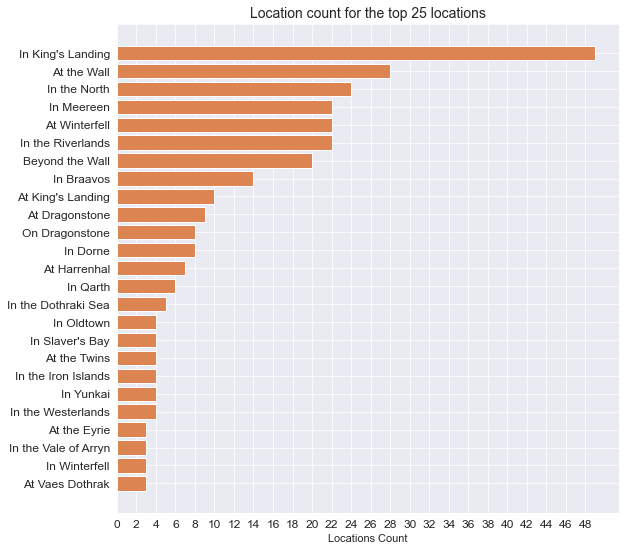

In [74]:
# Frequency dist of geographical locations
count = pd.DataFrame(data['geo'].value_counts().nlargest(25))

# Plotting the accumulated line count for the top 25 characters
fig, ax = plt.subplots(figsize=(9,9))
sns.set_style('darkgrid')
y = np.arange(len(count))
ax.barh(y, [int(i) for i in count.values], align='center', color = '#dd8552')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_yticks(y)
ax.set_xticks(np.arange(0,max(count.values),2))
ax.set_yticklabels(count.index, size=12)
ax.tick_params(axis='x', labelsize=12)
ax.set_xlabel('Locations Count', size=11)
ax.set_title('Location count for the top 25 locations' , size=14, weight=250, ha='center')

plt.show()


As expected, King's Landing is the most commen location and the North, Meereen, Riverlands and Winterfell are in the top too.  As one can tell, King's landing is denoted two  different ways. The same applies to Dragonstone. This however, does not appear to happend within an episode thus it will not be a problem.

Since this assignment builds a network per season,  it is relevant to look at the distribution of locations within each season:

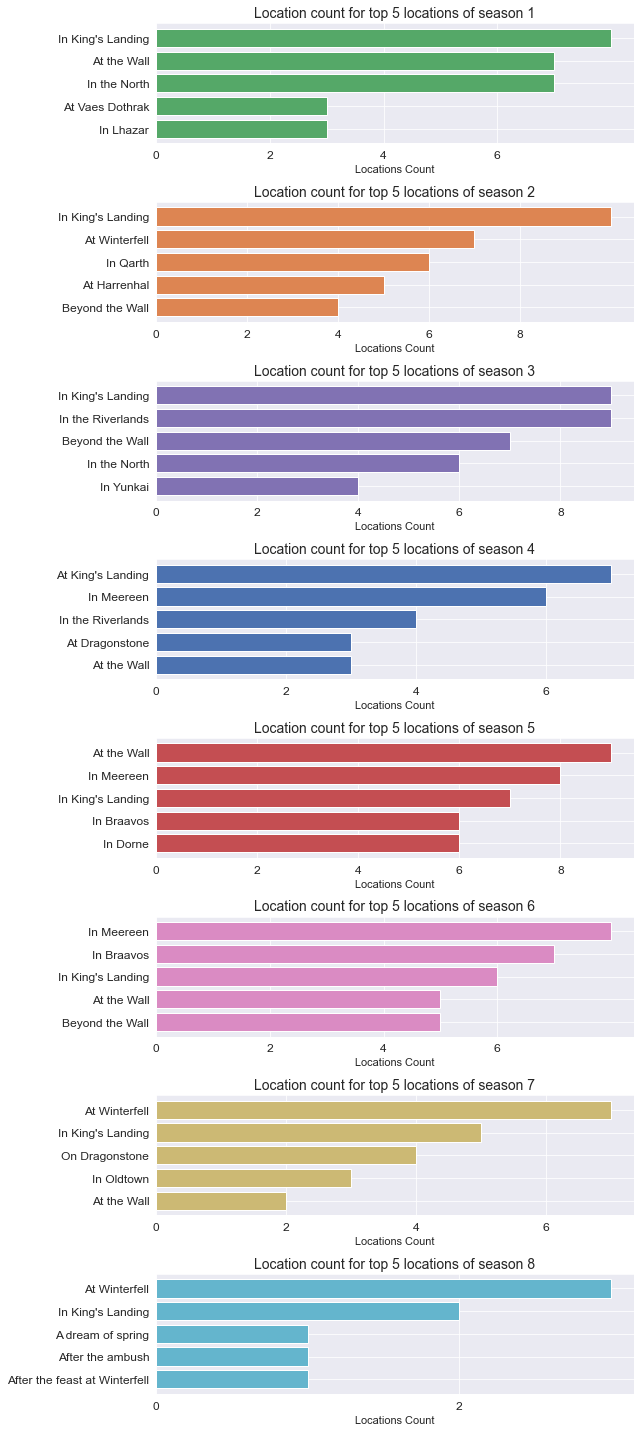

In [75]:
datagrouped = data.groupby(['season', 'geo'])['text'].count()
seasons = ['season1', 'season2', 'season3', 'season4', 'season5', 'Season_6',
       'Season_7', 'Season_8']

fig, ax = plt.subplots(8,1, figsize=(9,20))
for i, season in enumerate(seasons): 
    # Dict with location frequency distribution of season 
    s =  {idx[1]: int(val) for idx,val in zip(datagrouped.index, datagrouped.values) if idx[0] == season}
    

    s=dict(sorted(s.items(), key=lambda x: x[1], reverse=True)[:5])
    y = np.arange(len(s))
    ax[i].barh(y, s.values(), align='center', color = colors[i])
    ax[i].invert_yaxis()  # labels read top-to-bottom
    ax[i].set_yticks(y)
    ax[i].set_xticks(np.arange(0,max(s.values()),2))
    ax[i].set_yticklabels(s.keys(), size=12)
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].set_xlabel('Locations Count', size=11)
    ax[i].set_title('Location count for top 5 locations of season '+ str(i+1) , size=14, weight=250, ha='center')
    plt.tight_layout()
    
    sns.set_style('darkgrid')
    
plt.show()

King's Landing is in the top 5  of each season which might indicate that the Lannister's and Baratheon's who occupies the throne of King's landing will be mentioned often and that they will have strong and/or many connections as there most likely are many travelers in King's Landing.  

Winterfell and the North is mentioned quiet often as well meaning that e.g. the Starks will be very present in the graph. 

Season 5 and 6 are the only season which does not hold King's Landing as the most mentioned. Thus one shall keep an eye open for noticable change in the network strucure and communities in these networks. Meeren is introduced as the second most frequent location in season 4 and continues in season 5. This is interesting to look out for as well. 

Moreover, obe shall notice that there are not only geographical locations present. Thus some of the network data is based on events rather than locations. 

In [76]:
# Load houses dict from file. 
with open('../Data/houses.json') as json_file:
    houses = json.load(json_file)


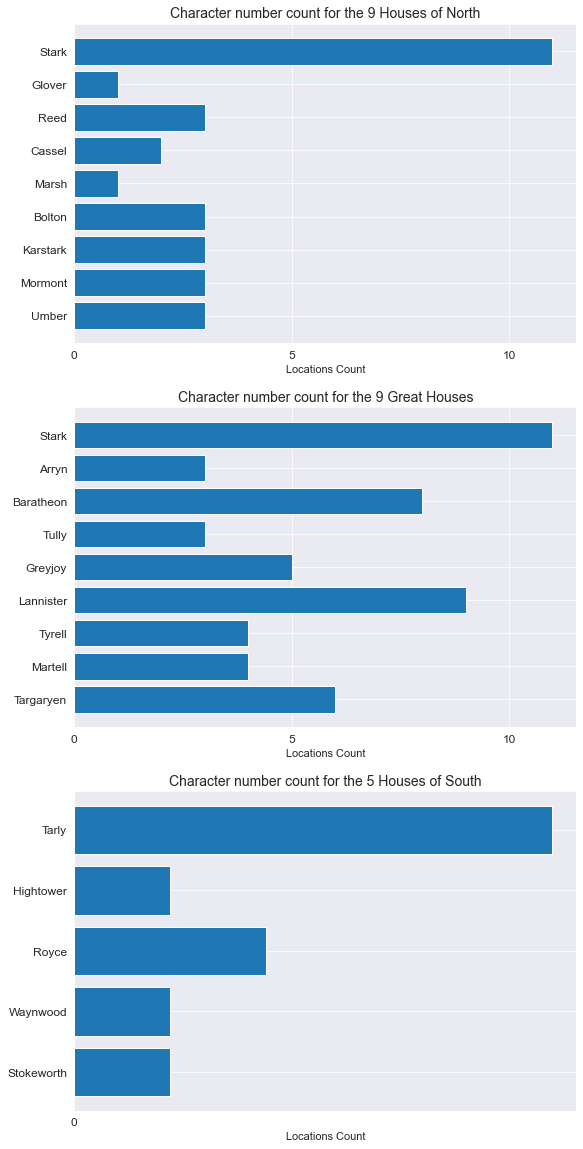

In [77]:
# Frequency distribution of characters 
for _,_,name in CN: 
    for key in houses.keys(): 
        for house in houses[key].keys(): 
            if house in name: 
                houses[key][house] +=1
                
# Remove if frequency is 0
for key in houses.keys():
    houses[key] = {k:v for k,v in houses[key].items() if v>0}

# Titels
T = [' Houses of North', ' Great Houses', ' Houses of South']
# Plotting the accumulated line count for the top 25 characters
fig, ax = plt.subplots(3,1,figsize=(9,20))
for i,key in enumerate(houses.keys()):
    y = np.arange(len(houses[key]))
    ax[i].barh(y, houses[key].values(), align='center')
    ax[i].invert_yaxis()  # labels read top-to-bottom
    ax[i].set_yticks(y)
    ax[i].set_xticks(np.arange(0,max(houses[key].values()),5))
    ax[i].set_yticklabels(houses[key].keys(), size=12)
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].set_xlabel('Locations Count', size=11)
    ax[i].set_title('Character number count for the ' + str(len(houses[key])) + T[i] , size=14, weight=250, ha='center')
plt.show()     

From the plots, one might get an idea of communities. It is possible that characters belonging the houses of south are more likely to be in same community. Same applies to character from a northern house. Moreover, one can imagine that characters within the same great house are likely to be in the same community. 

# Visualisation methods

In [78]:
def Plot(Samples, Names, color,numbins, name,xlab, ylab, save = False):
    """
    Function to plot histograms
    """
    fig, ax = plt.subplots(1,1)
    sns.set_style("darkgrid")
     
    MAX = np.max(Samples)
    MIN = np.min(Samples)
    bins = np.linspace(MIN,MAX,numbins)
    hist, edges = np.histogram (Samples, bins = bins, density = False)
    x = (edges[1:]+edges[:-1])/2
    width = bins[1]-bins[0]


    ax.bar(x, hist, width = width*0.9, color =  color)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(Names)
    
    if save:
    
        plt.savefig(name)
    
    plt.show()
    
    return

# Network building methods

* `NodeWeight`: Counts number of times each person is mentioned in the given documents.
* `GetEdges`: Compute which characters are connected by searching through relevant documents and find characters that are mentioned in the same document. 
* `GetLinkWeights`: Counts number of times two characters coappear in a document.
* `WeightedGraph`: Builds `networkx` weighted graph using the above methods. The function can also build directed graphs, however this was a part of an experiment with modularity of the weigted graph and is not used in this assignment. 
* `UnweightedGraph`: Builds `network`unweigthed graph using `GetEdges`. 

In [18]:
def NodeWeight(text, CN):
    """
    Methods for finding node size
    input: text: string including all relevant documents 
    input: CN: List of tripplets with names (name to search for, name to search for minus space, full name)
    returns: count_dict: frequency of names in text
    """
    
    CN0 = [i for i,_,_ in CN]
    CN1 = [i for _,i,_ in CN]
    CN2 = [i for _,_,i in CN]

    #remove space in names of interest 
    for cn0, cn1 in zip(CN0, CN1):
        text = text.replace(cn0, cn1)
        
    # Tokenize
    tokens = word_tokenize(text)
        
    count_dict = {name: 0 for name in CN2}
    
    for word in tokens:
        if word in CN1:
            
            idx = CN1.index(word)
            count_dict[CN2[idx]] = count_dict[CN2[idx]] + 1
            
    return count_dict

In [19]:
def GetEdges(Connections): 
    
    """
    Method to compute edges of network
    input: Connections: dict with keys = (season, episode, geograpic location) and value = set of characters mentioned in corresponding text
    
    returns: set of edges
    """
    
    # Get all edges
    Edges = []
    for g in Connections.values(): 
        Edges += [i for i in combinations(g, 2)] #for each fully connected subgraph, add all links in that graph 

    # Remove double. tripple etc. edges 
    Edges = [tuple(sorted(edge)) for edge in Edges]
    Edges = set(Edges)
    
    return Edges

In [20]:
def GetLinkWeights(Edges, Connections):
    
    """
    Method for computing edge weight
    input: Edges: Set of Edges
           Connections: dict with keys = (season, episode, geograpic location) and value = set of characters mentioned in corresponding text
           
    returns: WeightsInput: list of triplets each with a pair of connected nodes as well as the link weight. 
    """
    
    Weights = {edge: 0 for edge in Edges}
    for edge in Weights.keys(): 
        w = 0
        for s in Connections.values(): 
            if (edge[0] in s) and (edge[1] in s): 
                w +=1
        Weights[edge] = w

    WeightsInput = [(key[0],key[1], {'weight': val}) for key, val in Weights.items()] 
    
    return WeightsInput

In [21]:
def WeightedGraph(data, Connections, CleanCN, directed = False): 
    
    """
    Method for defining weighted graph in networkx
    input: Connections:  dict with keys = (season, episode, geograpic location) and value = set of characters mentioned in corresponding text            
           data: dataframe with text etc
           CleanCN: characterNames 
           directed: True if returned network is directed else false. 
           
    returns: Weighted graph or weighted directed graph.
             link_weight: weight of links. Used for cutof outside function
             
    """
    
    #Join text 
    alltext = ' '.join(data.text.values)
    
    # Compute node weights
    node_weight = NodeWeight(alltext, CleanCN)
    
    # Find links: 
    Edges = GetEdges(Connections)
    
    # Compute link weight
    link_weight = GetLinkWeights(Edges, Connections)
    
    # Initialise weighted graph: 
    if directed: 
        G_W = nx.MultiDiGraph()
    else: 
        G_W = nx.Graph()

    # Add nodes
    G_W.add_nodes_from(set().union(*Connections.values()), LouvainPartition = None, group = None, size = None)

    # Add node size (weight)
    for key, val in node_weight.items(): 
        G_W.nodes[key]['size'] = val

    
    if directed:
        edge1 = [(i,j,w['weight']) for i,j,w in link_weight]
        edge2 = [(j,i,w['weight']) for i,j,w in link_weight]
        G_W.add_weighted_edges_from(edge1 + edge2)
        
        
        
    else: 
        # Add links and weights
        G_W.add_edges_from(link_weight)
    
        
        # Remove nodes with zero degree
        #G_W = ZeroDegCutOff(G_W)
    
    return G_W
    

In [22]:
def UnweightedGraph(Connections):
    """
    Method for defining unweighted graph
    """
    
    # Compute links: 
    Edges = GetEdges(Connections)

    #Initialise
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(set().union(*Connections.values()), LouvainPartition = None, group = None)

    # Add edges to graph 
    G.add_edges_from(Edges)  
    
    # Remove nodes with zero degee
    #G = ZeroDegCutOff(G)
    
    return G

# Network science tools

_All information in this section is found in Network Science by Albert-Lázló Barabási_

To work with the networks, we have chosen to perform community detection og each graph.  The goal of community detection is to find structures of a network and thereby finding a partition into communities. 

For a graph with N nodes, there are $\frac{1}{e}\sum{^\inf}(\frac{j^N}{j})$ possible partitions. As the number grows fast with N, it is highly relevant use a good algorithm to compute a partition. 

There are several hypothesis regarding communities. In this case it is chosen to base the community detection on the random hypothesis: _"Randomly wired networks lack an inherent community structure."_ The modularity measure acknowledges this and measures the communities by comparing the link density of communities within a graph to a random graph. The modularity of a graph is computed as follows: 

$\sum_{c=1}^{n_c}[\frac{L_c}{L} - (\frac{k_c}{2L})^2]$

The modularity is implemented in `GraphModularity` and is a scaler in the range [-0.5,1.0]. 

The Louvain algorithm is a method to detect communities by optimising the modularity. It works by initially assigning each node to  their own comminity. Modularity is optimised by changing the partition by moving each node to the community that one of its adjacent nodes belongs to. The node will be moved the community of the neighbour which increase the modularity the most. Though,  if no positive increase is  gained dby moving the node it will stay. When no further improvements to the modularity can be donbe, communities are merged into one node and the algorithm  continues until optimal modularity is found. For this project the louvain algorithm `best_partition` from the `community` module is used to find the optimal partition. 

A general problem  with modularity maximisation algorithms is that they tend to force smaller communities into larger ones meaning some true communities might be lost. 


## Why the network science tools are right
The Louvain algorithm is an unsupervised learning algorithm meaning it is not nessesary to input size and shape(go to this article [towardsdatascience](https://towardsdatascience.com/louvain-algorithm-93fde589f58c)for more information). Contrary, graph partitioning methods ([Network Science Book (9.2)](http://networksciencebook.com/chapter/9#basics)) needs these input parameters. Social graphs are rather unpredictable and changes over time. Thus community detection algorithms is of advantage. 

In [23]:
def GraphModularity(graph, p):
    """
    Method to compute modularity of graph. Works for weighted  and unweigted graph 
    
    input: graph: networkX graph or list of nodes and attributes
           p: Partition definer: list containing attribute dict key and tuple with attribute dict values
           
    return: Modularity of graph
    """
    #Number of links in graph: 
    L = len(graph.edges())

    M = 0
    key = p[0] #
    p = p[1]
    deg = {i:0 for i in p}
    links = {i:0 for i in p}

    # loop through graph nodes: 
    for node in graph: 
        par = graph.nodes[node][key] # node partition 
        deg[par] += graph.degree[node] # node degree

        l = sum([w.get('weight', 1)/2 for n,w in graph[node].items() if graph.nodes[node][key] == graph.nodes[n][key]])

        links[par] += l


    for par in p: 
        M += links[par]/L - (deg[par]/(2*L))**2

    return M

# Building graphs and analysing with network science tools

_This section uses the network science tools described above on all seasons. A few comments are added to the outcome of the analysis_

All graph visualisations are performed with netwulfs "visualize". However, to maintain all configurations graph visualisations are saved to png format and displayed with markdown. 

Regarding the graph visualisations, only some charater names are shown. We only mean for the visualisations to show development over time and to get the genemral idea of communities.It is not an in-depth analysis of each characters connections. 

Furthermore, notice that the degree distribution of the weighted network of a  season is equal  to that of the unweighted network. Same applies to number of nodes and number of links. 

In [24]:
# Load list with characternames
CN = CharacterNames('../Data/characters.json')

## Season 1

In [25]:
# Get data: 
season = 'season1'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)

### Weighted graph

In [26]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
#nx.write_gpickle(G_W, "Graphs/Gseason1.gpickle")

# Visualise graph (uncomment to enter netwulfs interactive graph visualisation tool)
#WGraphVisu1, _ = nw.visualize(G_W)

##### The weighted graph of season 1 is as follows: 

From the weighted network of season 1, one might say that except from Khal Drogo and Daenerys, house Lannisters and house Starks consists of the most important characters. Jorah Mormont appears to be in two groups: With Daenerys and possibly with his brother Jeor Mormont.  However, the weight to Daenerys and Khal Drogo are larger than  those in the direction of his brother thus it points in the direction that houses alone cannot describe the connections. 

It appears from the network, that the first season focuses on one larger group of characters who are all often located the same place. Also, one can tell that there are a rather large amount of semi large characters who does not have any connections with large weights.

![title](../NetworkAnalysisImages/season1.png)

# Unweighted graph

In [27]:
# Define unweighted graph
G = UnweightedGraph(Connections)

### Partitioning unweighted graph with louvain

In [28]:
# Define partition
LouvainCommunities = community_louvain.best_partition(G)

# Add partition attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')

# save graph to pickle
#nx.write_gpickle(G, "Graphs/Gseason1unweight.gpickle")

# Visualise graph (uncomment to enter netwulfs interactive graph visualisation tool)
#GraphVisu1, _ = nw.visualize(G)

# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
M1= GraphModularity(G,partitioning)
print("Modularity of unweighted graph of " +  "season 1: " +  str(M1))

Modularity of unweighted graph of season 1: 0.2079401267850854


##### Communities of the unweighted graph of season 1: 
The modularity  is not too high,  hinting that the density if the subgraphs merely occured by chance. However, prior knowledge of the series allows one to notice that large parts of the communities are alligned with the truth. For instance, Jon Snow  joins the nights watch in season 1 and in the graph he is in same community as many of the night's watchmen. The blue-green community comprise mostm Lannisters and Starks which make sense compared to the series. The same applies to Daenerys Targaryen and her friends in the community at the bottom at the network. 

![minipic](../NetworkAnalysisImages/season1louvain1.png)

# Season 2

In [29]:
# Get data: 
season = 'season2'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)

### Weighted graph

In [30]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
#nx.write_gpickle(G_W, "Graphs/Gseason2.gpickle")

# Plot graph (uncomment to enter netwulfs interactive graph visualisation tool)
#WGraphVisu2, _ = nw.visualize(G_W)

##### The weighted graph of season 2 is as follows: 

In season 2 one can find the same tendencies as in the first season. However, it is evident that Daenerys and her allies are located in Essos; a location east of Westeros.

![drawing](../NetworkAnalysisImages/season2.png)

### Unweighted graph

### 

In [31]:
# Define graph
G = UnweightedGraph(Connections)

#### Louvain

In [32]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add partitiom to graph as attribute
nx.set_node_attributes(G, LouvainCommunities, 'group')
#nx.write_gpickle(G, "Graphs/Gseason2unweight.gpickle")

#Visualise graph (uncomment to enter netwulfs interactive graph visualisation tool)
#GraphVisu2, _ = nw.visualize(G)

# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
M2= GraphModularity(G,partitioning)
print("Modularity of unweighted of " +  "season 2: " +  str(M2))

Modularity of unweighted of season 2: 0.38192335873315786


##### The unweighted graph of season 2 is as follows: 

As expected, the modularity if season 2 is higher than in season 1.  Once again, Jon Snow is located in a community with character from the night watch. From the look of the community, they appear to be pretty seperated frpm the rest of the characters. Moreover, from the network one can tell that Arya Stark runs away from home in season 2. She is no longer in community with those of her house but in her community one can find some of the allies that she makes.


![drawing](../NetworkAnalysisImages/season2louvain.png)

## Season 3

In [33]:
# Get data: 
season = 'season3'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)

### Weighted graph

In [34]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph to pickle
#nx.write_gpickle(G_W, "Graphs/Gseason3.gpickle")

# Plot graph (uncomment to enter netwulfs interactive graph visualisation tool)
#WGraphVisu3, _ = nw.visualize(G_W)

##### The weighted graph of season 3 is as follows: 

One can tell that Daenerys and her allires are no longer seperated from the rest of the characters. Moreover, it is evident that while house Stark, house Lannister and house Baratheon are  still the most highligted spot in the network, more characters appear to coappear in several locations and/or several times. This applies toe.g. Ygritte and Jon Snow as well as Jojen Reed and Bran Stark. 


![drawing](../NetworkAnalysisImages/season3.png)

### Unweighted graph

In [35]:
# Define graph
G = UnweightedGraph(Connections)

#### Louvain

In [36]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
#nx.write_gpickle(G, "Graphs/Gseason3unweight.gpickle")

# Visualise graph (uncomment to enter netwulfs interactive graph visualisation tool)
#GraphVisu3, _ = nw.visualize(G)

# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
M3=GraphModularity(G,partitioning)
print("Modularity of unweighted of " +  "season 3: " +  str(M3))

Modularity of unweighted of season 3: 0.35450629956124463


##### Communities of unweighted graph of season 3 is as follows: 

The modularity measure of this partition is neither high nor low. The network for season 3 appears have been partitioned into 3 opposed to the earlier 4 communitues. From the graph one can tell that more or less all the characters who previously where in the large community with the Lannisters and Stark and the characters who belonged in the community with Jon Snow at the wall are now in one large community. All though, Cercei and Jamie Lannister as well as Sansa Stark are no longer in the community with the rest of the Starks.

![drawing](../NetworkAnalysisImages/season3louvain.png)

## Season 4

In [37]:
# Get data: 
season = 'season4'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)

### Weighted graph

In [38]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
#nx.write_gpickle(G_W, "Graphs/Gseason4.gpickle")

# Plot graph (uncomment to enter netwulfs interactive graph visualisation tool)
#WGraphVisu4, _ = nw.visualize(G_W)

##### The weighted graph of season 4 is as follows: 

The weighted graph of season 4 is, by look, more partitioned than the previous networks as more characters than previous have connections with large weights. It is still the characters  from house Lannister and house Stark (those you expect to be in King's Landing) who are mentioned the most. Arya, appears to still live away from her house. Daenerys and her allies has also developed connections with larger weights. From the network it appears that Daenerys might have arrived at Meereen and begon to free the slaves.


![drawing](../NetworkAnalysisImages/season4.png)

### Unweighted graph

In [39]:
# Define graph
G = UnweightedGraph(Connections)

#### Louvain

In [40]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
#nx.write_gpickle(G, "Graphs/Gseason4unweight.gpickle")

# Visualise graph  (uncomment to enter netwulfs interactive graph visualisation tool)
#GraphVisu4, _ = nw.visualize(G)

# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
M4= GraphModularity(G,partitioning)
print("Modularity of unweighted of " +  "season 4: " +  str(M4))

Modularity of unweighted of season 4: 0.43001033399197736


##### Communities of unweighted graph of season 4 is as follows: 

As expected the modularity is relatively high, and there are more communities than earlier seen. 

![drawing](../NetworkAnalysisImages/season4louvain.png)

## Season 5

In [41]:
season = 'season5'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)

### Weighted graph

In [42]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
#nx.write_gpickle(G_W, "Graphs/Gseason5.gpickle")

# Plot graph  (uncomment to enter netwulfs interactive graph visualisation tool)
#WGraphVisu5, _ = nw.visualize(G_W)

##### The weighted graph of season 5 is as follows: 

The network of season 5 have, even more pronounced than season 4, changed the weight of nodes and links. There are no large subgraph in the middle of the network where Lannisters and Starks are heavily connected. There are more emphasis than before on Daenerys and her allies. Sansa Stark, who had a smaller node size earlier has grown in importance and changed connections. Considering knowledge of the series - Sansa marries Ramsay Bolton in season 5 so it makes sense. Moreover, Tyrion, Stanns Baratheon and Jorah Mormont has a larger node size than earlier. 

![drawing](../NetworkAnalysisImages/season5.png)

### Unweighted graph

In [43]:
# Define graph
G = UnweightedGraph(Connections)

#### Louvain

In [44]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
#nx.write_gpickle(G, "Graphs/Gseason5unweight.gpickle")

# Visualise graph  (uncomment to enter netwulfs interactive graph visualisation tool)
#GraphVisu5, config = nw.visualize(G)

# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
M5= GraphModularity(G,partitioning)
print("Modularity of unweighted of " +  "season 5: " +  str(M5))

Modularity of unweighted of season 5: 0.5040393914148622


##### Communities of unweighted graph of season 5 is as follows: 

As expected, there the modularity is the highest so far and it appears the characters are divding into more and more seperate groups as time goes by.


![drawing](../NetworkAnalysisImages/season5louvain.png)

## Season 6

In [45]:
# Get data: 
season = 'Season_6'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)


### Weighted graph

In [46]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
#nx.write_gpickle(G_W, "Graphs/season6.gpickle")

# Visualise graph  (uncomment to enter netwulfs interactive graph visualisation tool)
#WGraphVisu6, _ = nw.visualize(G_W)


##### Weighted graph of season 6 is as follows: 

There now, from the look, appears to be one several subgraphs of, varying sizes, of which the characters have edges between them with large weights. As well as the remaining smaller characters. Cercei and Jaime Lannister appears to have new allie og enemy: High Sparrow. Also, Tommen Baratheon, the youngest son of Cersei and the now dead King Baratheon appearsto have gotten a larger rolw as well.   

![drawing](../NetworkAnalysisImages/season6.png)

### Unweighted graph

In [47]:
G = UnweightedGraph(Connections)

#### Louvain

In [48]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
#nx.write_gpickle(G, "Graphs/Gseason6unweight.gpickle")

# Visualise graph # Visualise graph  (uncomment to enter netwulfs interactive graph visualisation tool)
#GraphVisu6, _ = nw.visualize(G)

# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
M6 =  GraphModularity(G,partitioning)
print("Modularity of unweighted of " +  "season 6: " +  str(M6))

Modularity of unweighted of season 6: 0.5658745600000001


##### Communities of unweighted graph of season 6 is as follows: 

Regarding the community detection, season 6 shows the same tendencies as season 5.

![drawing](../NetworkAnalysisImages/season6louvain.png)

## Season 7

In [49]:
# Get data: 
season = 'Season_7'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)

### Weighted graph

In [50]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
#nx.write_gpickle(G_W, "Graphs/Gseason7.gpickle")

# Plot graph # Visualise graph  (uncomment to enter netwulfs interactive graph visualisation tool)
#WGraphVisu7, _ = nw.visualize(G_W)


##### Weighted graph of season 7 is as follows: 

Like in the first seasons, there appear to be 1 "group" of characters who has large weigths on connections among them.
Different from the first seasons is only Arya and Sansa of house Stark are mentioned frequently. Moreover, connections between Daenerys and the siblings Cersei and Tyrion Lannister has a large weight for the first time.

![drawing](../NetworkAnalysisImages/season7.png)

### Unweighted graph

In [51]:
G = UnweightedGraph(Connections)

#### Louvain

In [52]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
#nx.write_gpickle(G, "Graphs/Gseason7unweight.gpickle")

# Visualise graph # Visualise graph  (uncomment to enter netwulfs interactive graph visualisation tool)
#GraphVisu7, config = nw.visualize(G)

# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
M7 = GraphModularity(G,partitioning)
print("Modularity of unweighted of " +  "season 7: " +  str(M7))

Modularity of unweighted of season 7: 0.2166486313854245


##### Communities of unweighted graph of season 7 is as follows: 

Just as in the first season, the modularity is low.

![drawing](../NetworkAnalysisImages/season7louvain.png)

## Season 8

In [53]:
# Get data: 
season = 'Season_8'
data = GetSeasonData(season)

# Retrieve info of who is connected
Connections, CleanCN = GetFullyConnectedSubgraps(data, CN)

### Weighted graph

In [54]:
# Define graph
G_W = WeightedGraph(data, Connections, CleanCN)

# Save graph
#nx.write_gpickle(G_W, "Graphs/Gseason8.gpickle")

# Plot graph # Visualise graph  (uncomment to enter netwulfs interactive graph visualisation tool)
#WGraphVisu8, _ = nw.visualize(G_W)

##### Weighted graph of season 8 is as follows: 

Just as in season 7, there appers to be one larger "group". However the connections within the large group appears to be larger than in seson 6 and there are more larger nodes. 


![drawing](../NetworkAnalysisImages/season8.png)

### Unweighted graph

In [55]:
# Define graph
G = UnweightedGraph(Connections)

#### Louvain

In [56]:
# Louvain method 
LouvainCommunities = community_louvain.best_partition(G)

# Add attribute to graph
nx.set_node_attributes(G, LouvainCommunities, 'group')
#nx.write_gpickle(G, "Graphs/Gseason8unweight.gpickle")

# Visualise graph # Visualise graph  (uncomment to enter netwulfs interactive graph visualisation tool)
#GraphVisu8, _ = nw.visualize(G)


# Compute modularity of louvain partition
p = np.unique([i for i in LouvainCommunities.values()])
partitioning = ['group', p]
M8= GraphModularity(G,partitioning)
print("Modularity of unweighted of " +  "season 8: " +  str(M8))

Modularity of unweighted of season 8: 0.10399980575216404


##### Communities of unweighted graph of season 8 is as follows: 

The modularity is now very low. Indicating that the communities are close to random. This does make sense as the characters in the last season are located at the same place  at some point. 


![drawing](../NetworkAnalysisImages/season8louvain.png)

# Compare seasons

In [57]:
## Load graphs from file 
Weighted = {}
['Gseason' + str(i) + '.gpickle' for i in range(1,9)]
directory = '../Networks/Weighted'
for filename in os.listdir(directory):
    if filename.endswith(".gpickle"): 
        path = os.path.join(directory, filename)
        key = [i for i in path if i.isdigit()]
        Weighted[key[0]] = nx.read_gpickle(path)
        
        
## Load graphs from file 
Unweighted = {}
['Gseason' + str(i) + '.gpickle' for i in range(1,9)]
directory = '../Networks/Unweighted'
for filename in os.listdir(directory):
    if filename.endswith(".gpickle"): 
        path = os.path.join(directory, filename)
        key = [i for i in path if i.isdigit()]
        Unweighted[key[0]] = nx.read_gpickle(path)
        


In [58]:
M = np.array([[M1, M2, M3, M4, M5, M6, M7,M8]])
Mdf = pd.DataFrame(M, columns = ["Season"+ str(i) for i in range(1,9)], index = ['Modularity'])

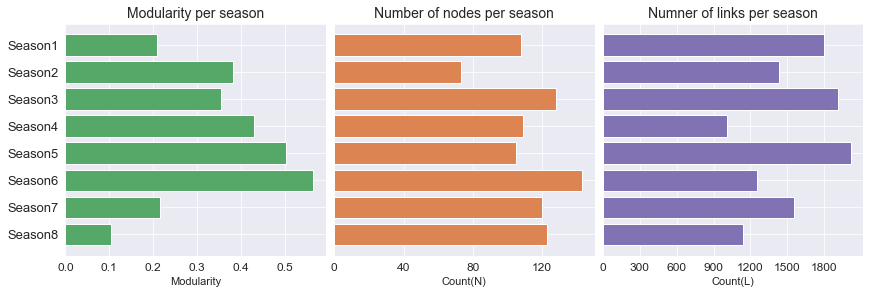

In [59]:
# Plot modularities, number of nodes and number of links
M = [M1, M2, M3, M4, M5, M6, M7,M8]
N =  {s: len(G.nodes) for s,G in Weighted.items()}
L = {s: len(G.edges) for s,G in Weighted.items()}
S = ["Season"+ str(i) for i in range(1,9)]
Data = [M, list(N.values()), list(L.values())]
xlabel = ['Modularity', 'Count(N)', 'Count(L)']
title = ['Modularity per season', 'Number of nodes per season', 'Numner of links per season']
stepsize = [0.1, 40, 300]


fig, ax = plt.subplots(1,3,figsize=(12,4))
y = np.arange(len(M))
for i in range(3):
    
    ax[i].barh(y,Data[i], align='center', color = colors[i])#)
    ax[i].invert_yaxis()  # labels read top-to-bottom
    ax[0].set_yticks(y)   
    ax[i].set_xticks(np.arange(0,max(Data[i]),stepsize[i]))
    
    if i == 0: 
        ax[i].set_yticklabels(S, size=13)
    else: 
         ax[i].set_yticklabels("")
        
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].set_xlabel(xlabel[i], size=11)
    ax[i].set_title(title[i] , size=14, weight=250, ha='center')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
sns.set_style('darkgrid')
plt.show()

As seen, the modularity starts of small, increases and then decreases. Related to the Networks one can deduct that the communities of season 1, 7 and 8 are close to those of a random graph. A random graph does not have communities. 

Seen in relation to the series itself, the modularities does not come as a surprice as it is the seasons in the middle where characters are of on their own adventures. 

Number of nodes decreases slightly as we reaches the end of the series. As one know, Game of Thrones does have a reputy of killing characters. This could be a reason for the decrease in characters. 

### Degree distribution, link weight distribution, node distribution

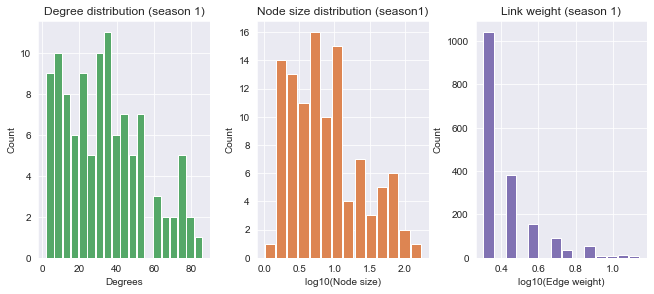

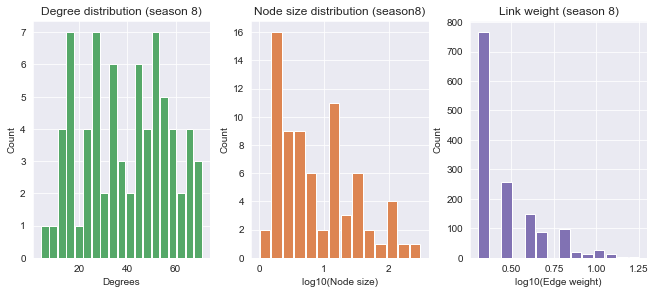

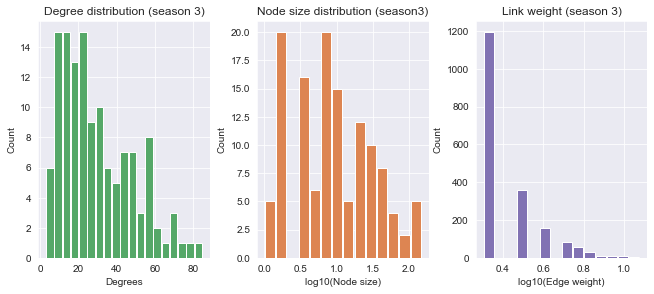

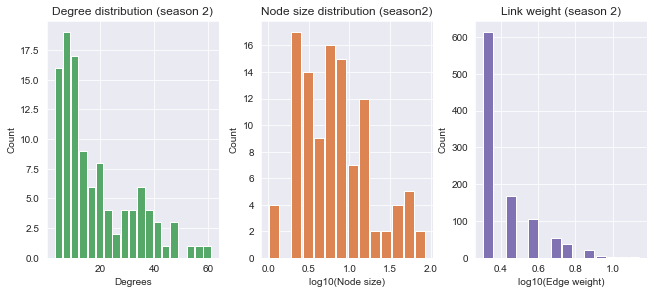

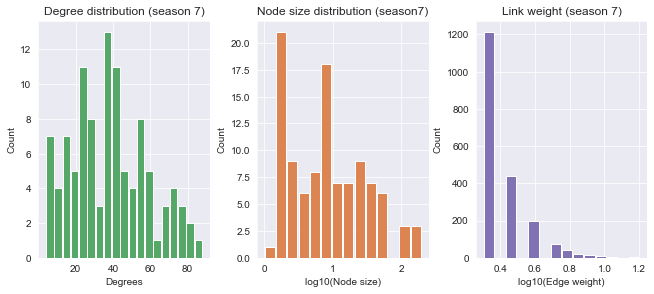

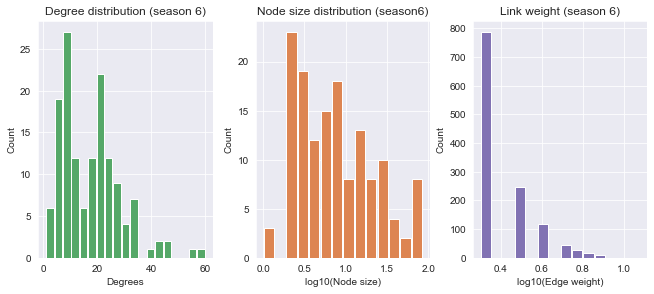

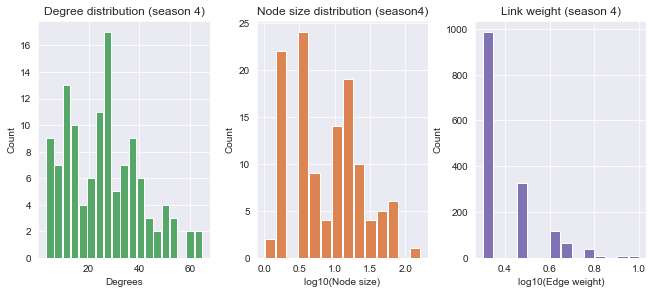

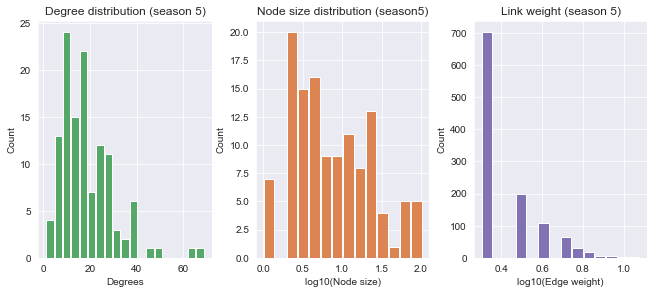

In [60]:
# Plot function: distribution plots
def Plot(Samples, titles, color,numbins, name,xlab, ylab, save = False):
    """
    Function to plot histograms
    """
    sns.set_style("darkgrid")
   
    fig, ax = plt.subplots(1,3,figsize = (9,4))

    for i in range(3):

        MAX = np.max(Samples[i])
        MIN = np.min(Samples[i])
        bins = np.linspace(MIN,MAX,numbins[i])
        hist, edges = np.histogram (Samples[i], bins = bins, density = False)
        x = (edges[1:]+edges[:-1])/2
        width = bins[1]-bins[0]


        ax[i].bar(x, hist, width = width*0.9, color =  color[i])
        ax[i].set_xlabel(xlab[i])
        ax[i].set_ylabel(ylab)
        ax[i].set_title(titles[i])
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        

    if save:
        plt.savefig(name)
    plt.show()
    
    return

for s, G in Weighted.items(): 
    
    titles = ["Degree distribution (season "  + str(s) +")",
             "Node size distribution (season"+ str(s) +")",
             "Link weight (season " + str(s) +")"]
    
    degreedist = [d for _,d in G.degree()]
    sizedist = [np.log10(val['size']+ 1**(-20)) for val in dict(G.nodes.data()).values()]
    weightdist = [np.log10(w['weight'] + 1**(-20)) for i,j,w in G.edges(data=True)]
    Samples = [degreedist, sizedist, weightdist]
    
    color = ['green','red', 'blue']
    numbins = [20,15, 15]
    xlab = ["Degrees","log10(Node size)","log10(Edge weight)"]
    ylab = "Count"
    
    Plot(Samples = Samples, titles = titles, color = colors, numbins = numbins, name =  None,
         xlab = xlab, ylab = ylab, save = False)


#### Comments on degree distribution:
_Notice that the degree distribution are the same for the weighted and unweighted network_
* Season 7 and 8 have more equally distributed degrees than the remaining seasons. 
* Season 2,5 and 6 especially, have only few characters with a high number of nodes.
* In season 3 and 7 some characters have a degree of 80. 

#### Comments on the node size and link weight distributions:
* Neither the node size nor the link weight distribution changes a lot through out the seasons.
* Link weight distribution has of season 7 and 8 generelly has higher weights than the remaining seasons.

Even though weight and node size distributions  does not change a lot throughout the series, the network visualisations show that node size of a character and link weights of link  connected to a charcter changes from throughout the series. 

# How the network analysis tools helped analysing the networks
The network analysis tools are used to analyse the social  structures in Game of Thrones. Louvain  helps understanding  the communities in the comlex social life of Game of Thrones and the modularity measure helps one to undestand  whether the season has actual communities or if the structures are close to random.

Prior knowledge lets  one know that in the first seasons and the last, the characters intersect in "one large mess" meaning relations changes throughout the season and characters move around a lot. In the middle seasons, charaters are of to their own adventure in a steady group of people. Meaning that while some charactes might change location, they dont change loyality as much and they move in groups. 

Using the louvain method, every graph was partitioned. Comparing the communities to prior knowledge, one will find that the communities are logically defined. The modularity measure shows that in season 1,  7  and 8, the community structure are more random than the communities of  the remainning seasons. Opposite, in the remianing seasons, characters more often  belongs to  a community, meaning they have chosen (or been forced into) a group of charaters and they spend their time in the same geographical location as their group while they rarely meet characters outside their community. One can find same tendencies in the weighted graph where the first seasons, as well as the last season has one larger "group" with large nodes that are connected with links with large weights. Starting in season 3, more of these "groups" begings to take form. They grow stronger (and changes slightly) throughtout to season 6. In season 7 and even more in season 8, one will once again find that there are only one of these groups. However, opposed to the first seasons,  there are multiple larger nodes that do not belong to one such "group".

Visualising the weighted and unweighted network helps one to understand how characters travel in and out of each others life. It visualises how the two strongest houses _Stark_ and _Lannister_/_Baratheon_ are splitted and how the power of Daeneries and her allies slowly grows.  

# What went well
* Community detection of the unweighted graph is alligned with what one could expect. Same applies  to the modularity measure. 
* The weighted graph visualisations nicely visualises how relations changes throughout the series and which characters are have the most screen time.
* When the modularity is known, degree distributions supports the idea of how random the communities are, even thought the.

# What is still missing? What could be improved?, Why?
To improve the community detection it is relevant to experiment with `Infomap` and observe whether the algorithm will be better at partitioning the network. 

**Perform community detection on the weigted graph**. This will allow the communities to be defined based on which connections are the "strongest". Even though Louvain detects structures that appears to be close to reality, one wonders how the communities wil look based on the weighted graphs. Community detection on the weighted graph could be performed with Louvain as follows: 
* Create a directed network based on the weighted undirected graph which is already created. Change each link such that each pair that are connected with a link is now strongly connected. If node `x` and `y` are connected, the link from `y` to `x` and the link from `x` to `y` should be weighted equally with the weight computed just as in the undirected weighted network. `WeightedGraph` is already capable of doing this. 
* Change the weight of each directed link as follows: If a link, $l_{x,y}$ goes from node x to an arbitrary node y, change the weight of $l_{x,y}$ by weighted it with the sum of weights of all edges outgoing from x.
* Change the modularity definitions to it works with directed graphs. This is done in the paper [Dugué15] by Dugué and Perez. Notice that $A_{i,j}$ in the case with a weighted directed graph i to j instead of the original definition of the adjacency matrix. 

Even though the above is relevant to look at, we can learn a lot form the analysis. We have found that in the first seasons there are only weakly defined communities whereas the middle seasons have more defined communities. Also, we have learned that house Lannister, Stark and Baratheon are most noticable in the beginning whereas Daenerys Targarien gains power towards the end. Furthermore, we have learned that there are fewer characters in the last seasons. This agrees perfectly with the large number pf deaths in the series. 

# References

[Dugué15] Nicolas Dugué, Anthony Perez. Directed Louvain: maximizing modularity in directed networks. [Research Report] Université d’Orléans. 2015. hal-01231784

#### Contribution

All members of the group contributed equally to this project.